In [1]:
import xlrd
import matplotlib.pyplot as plt
import numpy  as np
import pandas as pd
from pandas import Series, DataFrame
import scipy.stats as st
df=pd.read_csv('train_V2.csv')

In [2]:
df['matchType'].unique()

array(['squad-fpp', 'duo', 'solo-fpp', 'squad', 'duo-fpp', 'solo',
       'normal-squad-fpp', 'crashfpp', 'flaretpp', 'normal-solo-fpp',
       'flarefpp', 'normal-duo-fpp', 'normal-duo', 'normal-squad',
       'crashtpp', 'normal-solo'], dtype=object)

In [43]:
df["intwpp"] = round(df["winPlacePerc"]*(df["maxPlace"]-1))+1

In [49]:
def normPdf(x,mu,sigma):
    '''
    计算均值为mu，标准差为sigma的正态分布函数的密度函数值
    :param x: x值
    :param mu: 均值
    :param sigma: 标准差
    :return: x处的密度函数值
    '''
    return (1./np.sqrt(2*np.pi))*(np.exp(-(x-mu)**2/(2*sigma**2)))



def emgauss(dataArray,k,mu,sigma,step = 10):
    '''
    em算法估计高斯混合模型
    :param dataNum: 已知数据个数
    :param k: 每个高斯分布的估计系数
    :param mu: 每个高斯分布的估计均值
    :param sigma: 每个高斯分布的估计标准差
    :param step:迭代次数
    :return: em 估计迭代结束估计的参数值[k,mu,sigma]
    '''
    # 高斯分布个数
    n = len(k)
    # 数据个数
    dataNum = dataArray.size
    # 初始化gama数组
    gamaArray = np.zeros((n,dataNum))
    for s in range(step):
        for i in range(n):
            for j in range(dataNum):
                Sum = sum([k[t]*normPdf(dataArray[j],mu[t],sigma[t]) for t in range(n)])
                gamaArray[i][j] = k[i]*normPdf(dataArray[j],mu[i],sigma[i])/float(Sum)
        # 更新 mu
        for i in range(n):
            mu[i] = np.sum(gamaArray[i]*dataArray)/np.sum(gamaArray[i])
        # 更新 sigma
        for i in range(n):
            sigma[i] = np.sqrt(np.sum(gamaArray[i]*(dataArray - mu[i])**2)/np.sum(gamaArray[i]))
        # 更新系数k
        for i in range(n):
            k[i] = np.sum(gamaArray[i])/dataNum

    return [k,mu,sigma]

In [240]:
def doubledensity(mu1,sigma1,k1,x):
    N1 = np.sqrt(2 * np.pi * np.power(sigma1[0], 2))
    fac1 = np.power(x - mu1[0], 2) / np.power(sigma1[0], 2)
    density1=np.exp(-fac1/2)/N1
    N2 = np.sqrt(2 * np.pi * np.power(sigma1[1], 2))
    fac2 = np.power(x - mu1[1], 2) / np.power(sigma1[1], 2)
    density2=np.exp(-fac2/2)/N2
    #print(density1,density2)
    density=k1[0]*density1+k1[1]*density2
    #density=0.035*density1+0.965*density2
    return density

In [205]:
dfsquad = df[(df['matchType'] == 'squad')].reindex(columns = ['maxPlace','numGroups','winPlacePerc','intwpp','matchId','groupId'])
max(dfsquad['maxPlace'])

34

(array([239., 199., 180., 122., 133., 180., 225.,   0., 287., 408., 452.,
        548., 560., 530.,   0., 505., 408., 367., 323., 264., 208., 144.,
          0.,  78.,  73.,  40.,  26.,   8.,   4.,   1.]),
 array([ 2.        ,  2.86666667,  3.73333333,  4.6       ,  5.46666667,
         6.33333333,  7.2       ,  8.06666667,  8.93333333,  9.8       ,
        10.66666667, 11.53333333, 12.4       , 13.26666667, 14.13333333,
        15.        , 15.86666667, 16.73333333, 17.6       , 18.46666667,
        19.33333333, 20.2       , 21.06666667, 21.93333333, 22.8       ,
        23.66666667, 24.53333333, 25.4       , 26.26666667, 27.13333333,
        28.        ]),
 <a list of 30 Patch objects>)

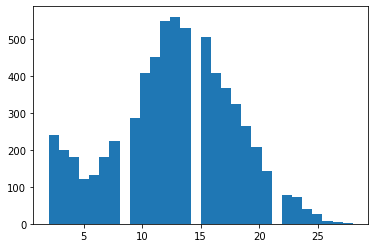

In [215]:
dfsquad = dfsquad.sort_values(by = ['matchId','intwpp'])
for i in range(len(dfsquad)):
    if dfsquad.iloc[i,3] == dfsquad.iloc[i,3]:
        continue
    else:
        dfsquad.iloc[i,3] = -1
countsquad2 = []
countsquad = []
for i in range(30):
    countsquad.append(0)
dfsquad2 = dfsquad.groupby(['matchId']).count()
jj = 0
for i in range(len(dfsquad2)):
    counttemp = []
    for j in range(jj,jj+int(dfsquad2.iloc[i,0])):
        counttemp.append(int(dfsquad.iloc[j,3]))
    for m in range(1,int(dfsquad.iloc[jj,0])+1):
        if m not in counttemp:
            countsquad[m] = countsquad[m]+1
            countsquad2.append(m)
    jj = jj+int(dfsquad2.iloc[i,0]) 
plt.hist(countsquad2,30)

In [217]:
countsquad5 = np.array(countsquad2)
np.std(countsquad5,ddof = 1)

5.163701546598621

In [256]:
countsquad2
numDict = dict()
for elem in countsquad2:
    if elem not in numDict.keys():
        numDict[elem] = 1
    else:
        numDict[elem] += 1
print(numDict)

{12: 547, 13: 559, 18: 322, 20: 207, 10: 407, 9: 286, 16: 407, 8: 224, 24: 39, 14: 529, 2: 238, 5: 121, 17: 366, 21: 143, 19: 263, 11: 451, 3: 198, 15: 504, 7: 179, 6: 132, 22: 77, 25: 25, 4: 179, 23: 72, 27: 3, 26: 7, 28: 0}


In [252]:
k0 = [0.3,0.7]
mu0 = [1,12]
sigma0 = [5.16,5.16]
step = 6
# 使用em算法估计参数
k1,mu1,sigma1 = emgauss(countsquad5,k0,mu0,sigma0,step)
# 输出参数的值
print("参数估计值:")
print("k1:",k1)
print("mu1:",mu1)
print("sigma1:",sigma1)

参数估计值:
k1: [0.03569292339495502, 0.9643070766050448]
mu1: [3.1532474986839456, 13.081487058680898]
sigma1: [1.2138821257639176, 4.90649709081083]


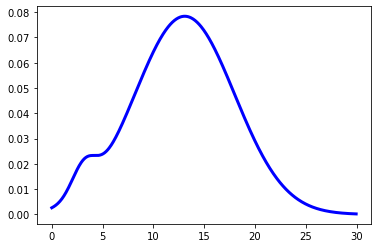

In [253]:
X = np.arange(0,30,0.05)
Y = doubledensity(mu1,sigma1,k1,X)
plt.plot(X,Y,'b-',linewidth=3)

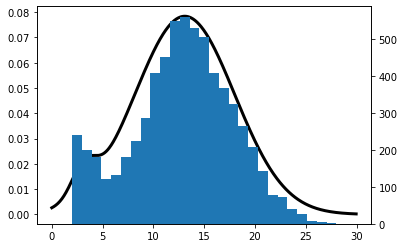

In [272]:
'''countsquad3 = []
testsquad = []
for i in range(27):
    countsquad3.append(0)
for i in range(len(countsquad2)):
    countsquad3[int(countsquad[i])] = countsquad3[int(countsquad2[i])]+1
for i in range(27):
    testsquad.append(i)
countsquad3 = np.array(countsquad3)
testsquad = np.array(testsquad)'''
fig,ax1 = plt.subplots()
plt.plot(X,Y,'k-',linewidth=3)
ax2=ax1.twinx()
#a = plt.bar(countsquad3,testsquad)
#autolabel(a)
plt.hist(countsquad2,27)
plt.show()

In [182]:
dfsolo = df[(df['matchType'] == 'solo')].reindex(columns = ['maxPlace','numGroups','winPlacePerc','intwpp','matchId','groupId'])
max(dfsolo['maxPlace'])

100

In [184]:
dfsolo.shape

(181943, 6)

(array([448., 450., 457., 456., 464., 472., 500., 508., 526., 545., 553.,
        557., 530., 485., 420., 304.,   0., 190., 123., 100.,  92.,  79.,
         73.,  66.,  67.,  67.,  54.,  48.,  46.,  54.,  47.,  53.,  50.,
          0.,  47.,  40.,  52.,  53.,  43.,  47.,  39.,  52.,  46.,  51.,
         60.,  70.,  73., 107.,  89.,   0.,  99., 109., 129., 115., 163.,
        139., 151., 139., 137., 154., 155., 136., 127., 135., 122., 117.,
          0., 110.,  81.,  90., 101.,  91., 103.,  77.,  82.,  70.,  74.,
         87.,  64.,  59.,  47.,  45.,  45.,   0.,  39.,  34.,  26.,  33.,
         19.,  35.,  22.,  11.,  15.,   7.,   6.,   5.,   3.,   2.,   1.,
          2.]),
 array([ 2.  ,  2.94,  3.88,  4.82,  5.76,  6.7 ,  7.64,  8.58,  9.52,
        10.46, 11.4 , 12.34, 13.28, 14.22, 15.16, 16.1 , 17.04, 17.98,
        18.92, 19.86, 20.8 , 21.74, 22.68, 23.62, 24.56, 25.5 , 26.44,
        27.38, 28.32, 29.26, 30.2 , 31.14, 32.08, 33.02, 33.96, 34.9 ,
        35.84, 36.78, 37.72, 38.66

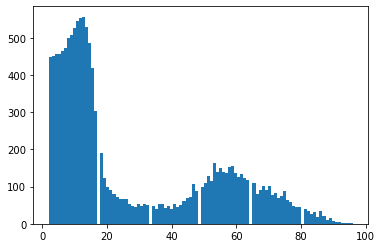

In [194]:
dfsolo = dfsolo.sort_values(by = ['matchId','intwpp'])
for i in range(len(dfsolo)):
    if dfsolo.iloc[i,3] == dfsolo.iloc[i,3]:
        continue
    else:
        dfsolo.iloc[i,3] = -1
countSolo2 = []
countSolo = []
for i in range(101):
    countSolo.append(0)
dfsolo2 = dfsolo.groupby(['matchId']).count()
jj = 0
for i in range(len(dfsolo2)):
    counttemp = []
    for j in range(jj,jj+int(dfsolo.iloc[jj,0])):
        counttemp.append(int(dfsolo.iloc[j,3]))
    for m in range(1,int(dfsolo.iloc[jj,0])+1):
        if m not in counttemp:
            countSolo[m] = countSolo[m]+1
            countSolo2.append(m)
    jj = jj+int(dfsolo.iloc[jj,0])    
plt.hist(countSolo2,100)

In [195]:
countsolo5 = np.array(countSolo2)
np.std(countsolo5,ddof = 1)

24.44793473893246

In [242]:
k0 = [0.8,0.2]
mu0 = [12,55]
sigma0 = [8,24.44]
step = 6
# 使用em算法估计参数
k1,mu1,sigma1 = emgauss(countsolo5,k0,mu0,sigma0,step)
# 输出参数的值
print("参数估计值:")
print("k1:",k1)
print("mu1:",mu1)
print("sigma1:",sigma1)

参数估计值:
k1: [0.2007918638324044, 0.7992081361675956]
mu1: [9.016640962397442, 32.19306597584008]
sigma1: [3.8218631800981773, 25.224725313115634]


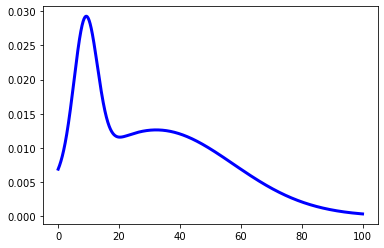

In [243]:
X = np.arange(0,100,0.05)
Y = doubledensity(mu1,sigma1,k1,X)
plt.plot(X,Y,'b-',linewidth=3)

In [160]:
dfduo = df[(df['matchType'] == 'duo')].reindex(columns = ['maxPlace','numGroups','winPlacePerc','intwpp','matchId','groupId'])

In [163]:
max(dfduo['maxPlace'])

51

(array([ 71., 142., 189., 210., 189., 149., 129., 115.,   0., 100., 114.,
         82.,  89.,  85.,  92.,  73.,  84.,   0., 108., 145., 180., 205.,
        271., 319., 334., 339.,   0., 352., 369., 341., 292., 280., 252.,
        222., 213.,   0., 187., 166., 134., 134.,  96.,  83.,  65.,  47.,
          0.,  16.,  19.,  14.,   7.,   4.,   1.,   1.,   1.]),
 array([ 2.        ,  2.88679245,  3.77358491,  4.66037736,  5.54716981,
         6.43396226,  7.32075472,  8.20754717,  9.09433962,  9.98113208,
        10.86792453, 11.75471698, 12.64150943, 13.52830189, 14.41509434,
        15.30188679, 16.18867925, 17.0754717 , 17.96226415, 18.8490566 ,
        19.73584906, 20.62264151, 21.50943396, 22.39622642, 23.28301887,
        24.16981132, 25.05660377, 25.94339623, 26.83018868, 27.71698113,
        28.60377358, 29.49056604, 30.37735849, 31.26415094, 32.1509434 ,
        33.03773585, 33.9245283 , 34.81132075, 35.69811321, 36.58490566,
        37.47169811, 38.35849057, 39.24528302, 40.132075

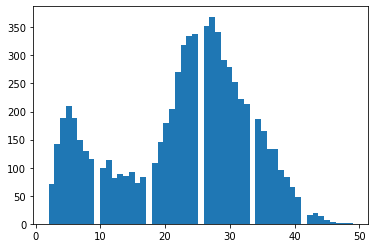

In [165]:
dfduo = dfduo.sort_values(by = ['matchId','intwpp'])
for i in range(len(dfduo)):
    if dfduo.iloc[i,3] == dfduo.iloc[i,3]:
        continue
    else:
        dfduo.iloc[i,3] = -1
countduo2 = []
countduo = []
for i in range(52):
    countduo.append(0)
dfduo2 = dfduo.groupby(['matchId']).count()
jj = 0
for i in range(len(dfduo2)):
    counttemp = []
    for j in range(jj,jj+int(dfduo2.iloc[i,0])):
        counttemp.append(int(dfduo.iloc[j,3]))
    for m in range(1,int(dfduo.iloc[jj,0])+1):
        if m not in counttemp:
            countduo[m] = countduo[m]+1
            countduo2.append(m)
    jj = jj+int(dfduo2.iloc[i,0]) 

Text(0.5, 0, '缺失值的位置')

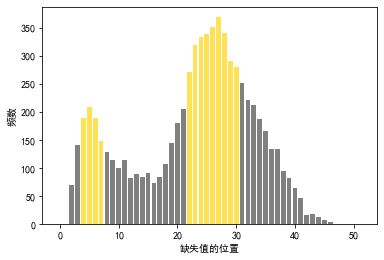

In [326]:
#plt.hist(countduo2,48,color = ('y'))
fig,ax1 = plt.subplots()
plt.rcParams['font.sans-serif'] = ['SimHei']
a = plt.bar(testduo,countduo3,color=['gray']*4+['#FDE255']*4+['gray']*14+['#FDE255']*9+['gray']*17)
ax1.set_ylabel('频数') 
ax1.set_xlabel('缺失值的位置') 

In [166]:
countduo5 = np.array(countduo2)
np.std(countduo5,ddof = 1)

10.242870324532568

In [276]:
k0 = [0.363,0.637]
mu0 = [5,27]
sigma0 = [10.24,10.24]
step = 6
# 使用em算法估计参数
k1,mu1,sigma1 = emgauss(countduo5,k0,mu0,sigma0,step)
# 输出参数的值
print("参数估计值:")
print("k1:",k1)
print("mu1:",mu1)
print("sigma1:",sigma1)

参数估计值:
k1: [0.21997831116930705, 0.7800216888306929]
mu1: [7.148308359782472, 27.223217635025645]
sigma1: [3.466429487643154, 6.514990777110895]


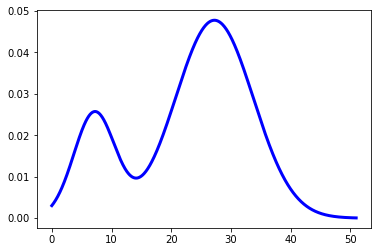

In [277]:
X = np.arange(0,51,0.05)
Y = doubledensity(mu1,sigma1,k1,X)
plt.plot(X,Y,'b-',linewidth=3)

In [289]:
countduo3 = []
testduo = []
for i in range(52):
    countduo3.append(0)
for i in range(len(countduo2)):
    countduo3[int(countduo2[i])] = countduo3[int(countduo2[i])]+1
for i in range(52):
    testduo.append(i)
countduo3 = np.array(countduo3)
testduo = np.array(testduo)

In [299]:
testduo

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51])

<Figure size 432x288 with 0 Axes>

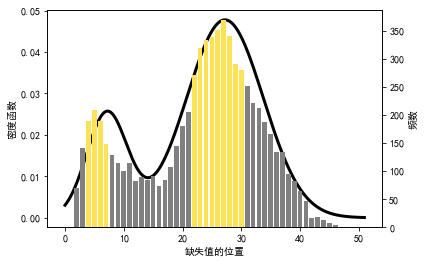

In [317]:
import matplotlib as mpl

figsave=plt.gcf()
plt.rcParams['font.sans-serif'] = ['SimHei']
fig,ax1 = plt.subplots()
plt.plot(X,Y,'k-',linewidth=3)
ax1.set_xlabel('缺失值的位置')
ax1.set_ylabel('密度函数')
ax2=ax1.twinx()
a = plt.bar(testduo,countduo3,color=['gray']*4+['#FDE255']*4+['gray']*14+['#FDE255']*9+['gray']*17)
#plt.hist(countduo2,48,color = ('y'))
ax2.set_ylabel('频数') 
plt.show()
figsave.savefig('./duo类型比赛的缺失值分布')

(array([ 3.,  4.,  8.,  6.,  0.,  3.,  5.,  5.,  0.,  4.,  2.,  1.,  0.,
         2.,  4.,  1.,  0.,  5.,  8.,  7.,  0.,  6., 11., 11.,  0., 16.,
        18., 10.,  0., 11.,  8.,  9.,  0.,  5.,  4.,  4.,  0.,  2.,  3.,
         4.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.]),
 array([ 2.        ,  2.75471698,  3.50943396,  4.26415094,  5.01886792,
         5.77358491,  6.52830189,  7.28301887,  8.03773585,  8.79245283,
         9.54716981, 10.30188679, 11.05660377, 11.81132075, 12.56603774,
        13.32075472, 14.0754717 , 14.83018868, 15.58490566, 16.33962264,
        17.09433962, 17.8490566 , 18.60377358, 19.35849057, 20.11320755,
        20.86792453, 21.62264151, 22.37735849, 23.13207547, 23.88679245,
        24.64150943, 25.39622642, 26.1509434 , 26.90566038, 27.66037736,
        28.41509434, 29.16981132, 29.9245283 , 30.67924528, 31.43396226,
        32.18867925, 32.94339623, 33.69811321, 34.45283019, 35.20754717,
        35.96226415, 36.71698113, 37

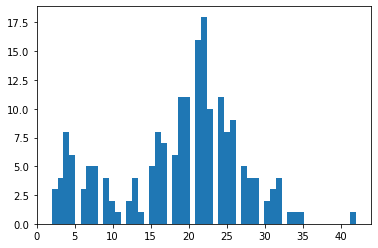

In [48]:
dfduofpp = dfduofpp.sort_values(by = ['matchId','intwpp'])
for i in range(len(dfduofpp)):
    if dfduofpp.iloc[i,3] == dfduofpp.iloc[i,3]:
        continue
    else:
        dfduofpp.iloc[i,3] = -1
countduofpp2 = []
countduofpp = []
for i in range(52):
    countduofpp.append(0)
dfduofpp2 = dfduofpp.groupby(['matchId']).count()
jj = 0
for i in range(len(dfduofpp2)):
    counttemp = []
    for j in range(jj,jj+int(dfduofpp2.iloc[i,0])):
        counttemp.append(int(dfduofpp.iloc[j,3]))
    for m in range(1,int(dfduofpp.iloc[jj,0])+1):
        if m not in counttemp:
            countduofpp[m] = countduofpp[m]+1
            countduofpp2.append(m)
    jj = jj+int(dfduofpp2.iloc[i,0]) 
plt.hist(countduofpp2,53)

In [50]:
countcrashfpp5 = np.array(countcrashfpp2)

In [51]:
np.mean(countcrashfpp5)

18.74742268041237

In [52]:
np.std(countcrashfpp5,ddof = 1)

8.13316109425987

In [141]:
k0 = [0.3,0.7]
mu0 = [4,23]
sigma0 = [8.13,8.13]
step = 6
# 使用em算法估计参数
k1,mu1,sigma1 = emgauss(countcrashfpp5,k0,mu0,sigma0,step)
# 输出参数的值
print("参数估计值:")
print("k1:",k1)
print("mu1:",mu1)
print("sigma1:",sigma1)

参数估计值:
k1: [0.1851983907672384, 0.8148016092327617]
mu1: [5.460957954273285, 21.76733802960225]
sigma1: [2.2290108994943805, 5.512864275727925]


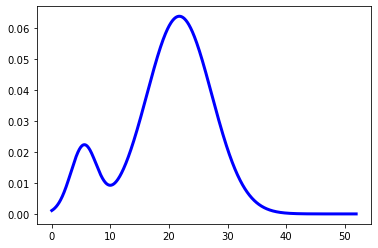

In [144]:
X = np.arange(0,52,0.05)
Y = doubledensity(mu1,sigma1,k1,X)
plt.plot(X,Y,'b-',linewidth=3)

In [146]:
0.12+0.88

1.0

In [ ]:
max(dfcrashfpp['maxPlace'])

In [247]:
dfcrashtpp = df[(df['matchType'] == 'crashtpp')].reindex(columns = ['maxPlace','numGroups','winPlacePerc','intwpp','matchId','groupId'])
max(dfcrashtpp['numGroups'])
#dfcrashtpp.shape

44

(array([1., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 1.]),
 array([ 2.        ,  2.51111111,  3.02222222,  3.53333333,  4.04444444,
         4.55555556,  5.06666667,  5.57777778,  6.08888889,  6.6       ,
         7.11111111,  7.62222222,  8.13333333,  8.64444444,  9.15555556,
         9.66666667, 10.17777778, 10.68888889, 11.2       , 11.71111111,
        12.22222222, 12.73333333, 13.24444444, 13.75555556, 14.26666667,
        14.77777778, 15.28888889, 15.8       , 16.31111111, 16.82222222,
        17.33333333, 17.84444444, 18.35555556, 18.86666667, 19.37777778,
        19.88888889, 20.4       , 20.91111111, 21.42222222, 21.93333333,
        22.44444444, 22.95555556, 23.46666667, 23.97777778, 24.48888889,
        25.        ]),
 <a list of 45 Patch objects>)

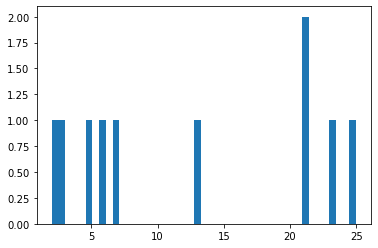

In [249]:
dfcrashtpp = dfcrashtpp.sort_values(by = ['matchId','intwpp'])
for i in range(len(dfcrashtpp)):
    if dfcrashtpp.iloc[i,3] == dfcrashtpp.iloc[i,3]:
        continue
    else:
        dfcrashtpp.iloc[i,3] = -1
countcrashtpp2 = []
countcrashtpp = []
for i in range(45):
    countcrashtpp.append(0)
dfcrashtpp2 = dfcrashtpp.groupby(['matchId']).count()
jj = 0
for i in range(len(dfcrashtpp2)):
    counttemp = []
    for j in range(jj,jj+int(dfcrashtpp2.iloc[i,0])):
        counttemp.append(int(dfcrashtpp.iloc[j,3]))
    for m in range(1,int(dfcrashtpp.iloc[jj,0])+1):
        if m not in counttemp:
            countcrashtpp[m] = countcrashtpp[m]+1
            countcrashtpp2.append(m)
    jj = jj+int(dfcrashtpp2.iloc[i,0]) 
plt.hist(countcrashtpp2,45)

In [153]:
dfflarefpp = df[(df['matchType'] == 'flarefpp')].reindex(columns = ['maxPlace','numGroups','winPlacePerc','intwpp','matchId','groupId'])
max(dfflarefpp['numGroups'])
dfflarefpp.shape

(718, 6)

(array([2., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.]),
 array([ 2.        ,  2.33333333,  2.66666667,  3.        ,  3.33333333,
         3.66666667,  4.        ,  4.33333333,  4.66666667,  5.        ,
         5.33333333,  5.66666667,  6.        ,  6.33333333,  6.66666667,
         7.        ,  7.33333333,  7.66666667,  8.        ,  8.33333333,
         8.66666667,  9.        ,  9.33333333,  9.66666667, 10.        ,
        10.33333333, 10.66666667, 11.        , 11.33333333, 11.66666667,
        12.        ]),
 <a list of 30 Patch objects>)

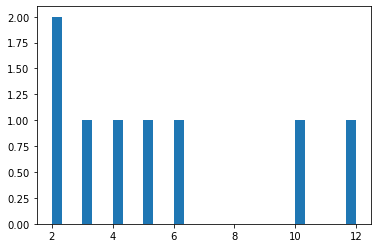

In [151]:
dfflarefpp = dfflarefpp.sort_values(by = ['matchId','intwpp'])
for i in range(len(dfflarefpp)):
    if dfflarefpp.iloc[i,3] == dfflarefpp.iloc[i,3]:
        continue
    else:
        dfflarefpp.iloc[i,3] = -1
countflarefpp2 = []
countflarefpp = []
for i in range(30):
    countflarefpp.append(0)
dfflarefpp2 = dfflarefpp.groupby(['matchId']).count()
jj = 0
for i in range(len(dfflarefpp2)):
    counttemp = []
    for j in range(jj,jj+int(dfflarefpp2.iloc[i,0])):
        counttemp.append(int(dfflarefpp.iloc[j,3]))
    for m in range(1,int(dfflarefpp.iloc[jj,0])+1):
        if m not in counttemp:
            countflarefpp[m] = countflarefpp[m]+1
            countflarefpp2.append(m)
    jj = jj+int(dfflarefpp2.iloc[i,0]) 
plt.hist(countflarefpp2,30)

In [154]:
#均匀分布

In [157]:
dfflaretpp = df[(df['matchType'] == 'flaretpp')].reindex(columns = ['maxPlace','numGroups','winPlacePerc','intwpp','matchId','groupId'])
max(dfflaretpp['maxPlace'])
#dfflaretpp.shape

28

(array([4., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 2., 0., 3., 0., 3., 0.,
        6., 2., 0., 2., 0., 2., 1., 0., 0., 0., 0., 1.]),
 array([ 2.        ,  2.5862069 ,  3.17241379,  3.75862069,  4.34482759,
         4.93103448,  5.51724138,  6.10344828,  6.68965517,  7.27586207,
         7.86206897,  8.44827586,  9.03448276,  9.62068966, 10.20689655,
        10.79310345, 11.37931034, 11.96551724, 12.55172414, 13.13793103,
        13.72413793, 14.31034483, 14.89655172, 15.48275862, 16.06896552,
        16.65517241, 17.24137931, 17.82758621, 18.4137931 , 19.        ]),
 <a list of 29 Patch objects>)

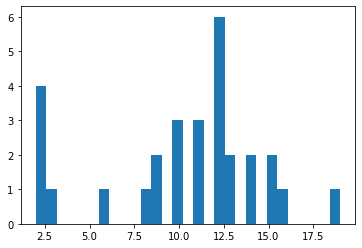

In [158]:
dfflaretpp = dfflaretpp.sort_values(by = ['matchId','intwpp'])
for i in range(len(dfflaretpp)):
    if dfflaretpp.iloc[i,3] == dfflaretpp.iloc[i,3]:
        continue
    else:
        dfflaretpp.iloc[i,3] = -1
countflaretpp2 = []
countflaretpp = []
for i in range(29):
    countflaretpp.append(0)
dfflaretpp2 = dfflaretpp.groupby(['matchId']).count()
jj = 0
for i in range(len(dfflaretpp2)):
    counttemp = []
    for j in range(jj,jj+int(dfflaretpp2.iloc[i,0])):
        counttemp.append(int(dfflaretpp.iloc[j,3]))
    for m in range(1,int(dfflaretpp.iloc[jj,0])+1):
        if m not in counttemp:
            countflaretpp[m] = countflaretpp[m]+1
            countflaretpp2.append(m)
    jj = jj+int(dfflaretpp2.iloc[i,0]) 
plt.hist(countflaretpp2,29)

In [159]:
len(countflaretpp2)

29